# Monte Carlo Simulation of SIS Model on Complex Networks

This notebook performs Monte Carlo simulations of the Susceptible-Infected-Susceptible (SIS) epidemic model on Erdős-Rényi (ER) and Barabási-Albert (BA) networks. The goal is to compute the stationary fraction of infected nodes, ρ, as a function of the infection probability β for different recovery probabilities μ and network structures.

## Parameters
- **Networks**: ER and BA with 1000 nodes, average degrees ⟨k⟩=4 and ⟨k⟩=6.
- **Infection probability (β)**: 0.00 to 0.30 in steps of 0.01.
- **Recovery probability (μ)**: 0.2 and 0.4.
- **Simulation parameters**: 
  - `N_rep=50` (repetitions per configuration),
  - `T_max=1000` (time steps),
  - `T_trans=900` (transient steps discarded).

In [1]:
import networkx as nx
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm

# Network generation
n_nodes = 1000
networks = {
    'ER_k4': nx.erdos_renyi_graph(n_nodes, 4/(n_nodes-1)),
    'ER_k6': nx.erdos_renyi_graph(n_nodes, 6/(n_nodes-1)),
    'BA_k4': nx.barabasi_albert_graph(n_nodes, 2),
    'BA_k6': nx.barabasi_albert_graph(n_nodes, 3)
}

# Precompute adjacency matrices
adjacency_matrices = {name: nx.adjacency_matrix(net) for name, net in networks.items()}


## Simulation Function
Vectorized implementation to handle multiple repetitions efficiently.

In [2]:
def simulate_sis(adj_matrix, beta, mu, n_rep=50, t_max=1000, t_trans=900, p0=0.2):
    n_nodes = adj_matrix.shape[0]
    current_states = (np.random.rand(n_rep, n_nodes) < p0).astype(int)
    p_sum = 0.0
    adj_matrix = adj_matrix.astype(float)
    
    for t in tqdm(range(t_max), desc=f"β={beta:.2f}, μ={mu}", leave=False):
        # Recovery
        infected_mask = (current_states == 1)
        recovery_probs = np.random.rand(n_rep, n_nodes)
        new_states = current_states.copy()
        new_states[np.logical_and(infected_mask, recovery_probs < mu)] = 0
        
        # Infection
        susceptible_mask = (current_states == 0)
        infected_neighbors = np.array([adj_matrix.dot(current_states[r]) for r in range(n_rep)])
        prob_infect = 1 - (1 - beta) ** infected_neighbors
        infection_probs = np.random.rand(n_rep, n_nodes)
        infected = np.logical_and(susceptible_mask, infection_probs < prob_infect)
        new_states[infected] = 1
        
        current_states = new_states
        if t >= t_trans:
            p_sum += current_states.mean(axis=1).sum()
    
    return p_sum / (n_rep * (t_max - t_trans))


## Run Simulations
Execute simulations for all combinations of μ, networks, and β values.

In [3]:
mu_values = [0.2, 0.4]
beta_values = np.arange(0, 0.31, 0.01)
results = {mu: {net: {} for net in networks} for mu in mu_values}

for mu in mu_values:
    for net_name in networks:
        adj = adjacency_matrices[net_name]
        for beta in tqdm(beta_values, desc=f"μ={mu}, {net_name}"):
            results[mu][net_name][beta] = simulate_sis(adj, beta, mu)


μ=0.4, BA_k6: 100%|██████████| 31/31 [00:34<00:00,  1.10s/it]     


## Theoretical Prediction (Mean-Field Approximation)
For ER networks, solve the mean-field equation: 
$$ρ = \frac{β ⟨k⟩ ρ (1 - ρ)}{μ + β ⟨k⟩ ρ}$$

In [4]:
from scipy.optimize import fsolve

def mean_field_rho(beta, mu, k):
    def equation(rho):
        return rho - (beta * k * rho * (1 - rho)) / (mu + beta * k * rho)
    rho_initial = 0.5
    rho_solution = fsolve(equation, rho_initial)[0]
    return rho_solution if rho_solution > 0 else 0.0

# Compute theoretical values for ER
theory = {mu: {'ER_k4': {}, 'ER_k6': {}} for mu in mu_values}
for mu in mu_values:
    for net in ['ER_k4', 'ER_k6']:
        k = 4 if 'k4' in net else 6
        theory[mu][net] = {beta: mean_field_rho(beta, mu, k) for beta in beta_values}


/opt/homebrew/Caskroom/miniforge/base/envs/cn/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


## Plot Results
Compare simulation and theoretical results for ER networks and all networks for BA.

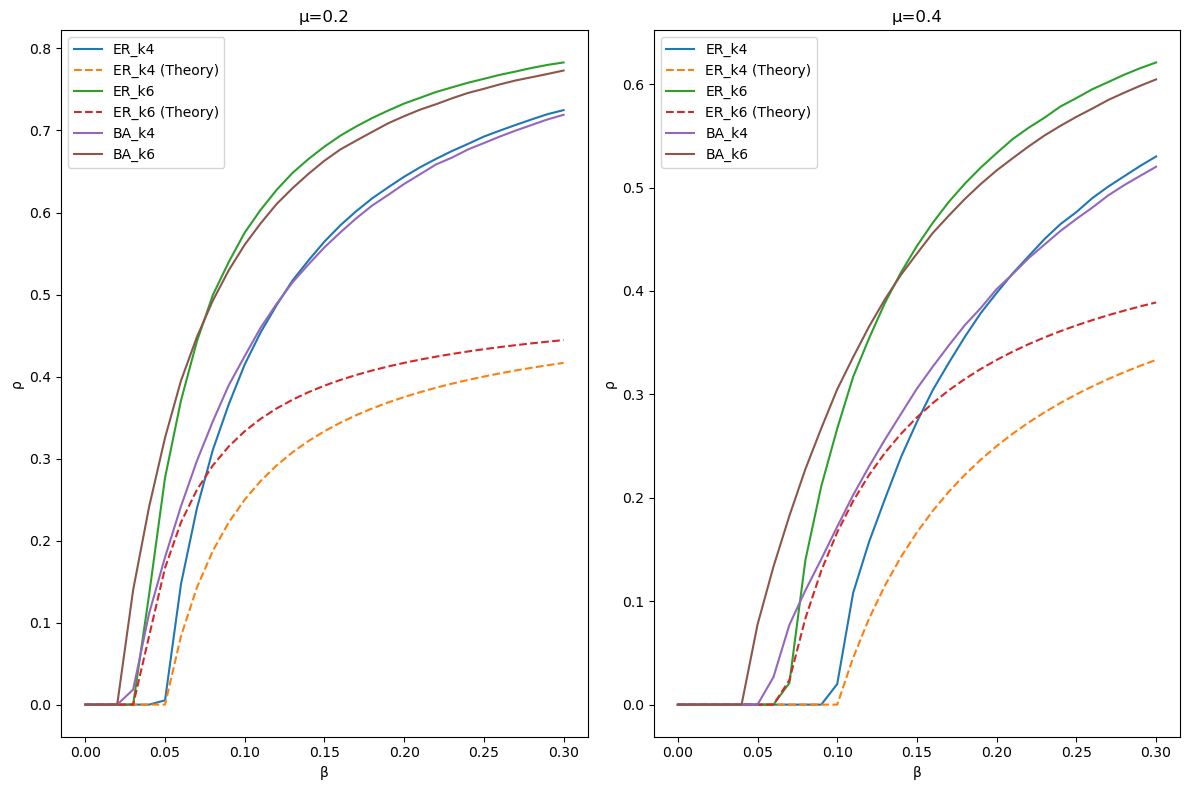

In [5]:
plt.figure(figsize=(12, 8))
for mu_idx, mu in enumerate(mu_values):
    plt.subplot(1, 2, mu_idx+1)
    for net in networks:
        betas = list(results[mu][net].keys())
        rhos = [results[mu][net][b] for b in betas]
        plt.plot(betas, rhos, label=net)
        if 'ER' in net:
            theory_rhos = [theory[mu][net][b] for b in betas]
            plt.plot(betas, theory_rhos, '--', label=f'{net} (Theory)')
    plt.xlabel('β')
    plt.ylabel('ρ')
    plt.title(f'μ={mu}')
    plt.legend()
plt.tight_layout()
plt.show()


## Discussion

### ER vs BA Networks
- **ER Networks**: Homogeneous degree distribution leads to a gradual increase in ρ with β. The epidemic threshold is lower compared to BA.
- **BA Networks**: Presence of hub nodes facilitates rapid spreading, resulting in higher ρ at lower β. The epidemic threshold is lower than predicted by mean-field.

### Theoretical vs Simulation
- Mean-field theory aligns well with ER simulations but underestimates ρ for BA due to heterogeneity in degree distribution.

### Parameters
- **N_rep=50**, **T_max=1000**, **T_trans=900** ensure convergence to stationary state. Results may vary slightly due to stochasticity.
